# Deep Learning: Models and Optimization
## *Project: Generative Adversarial Networks*

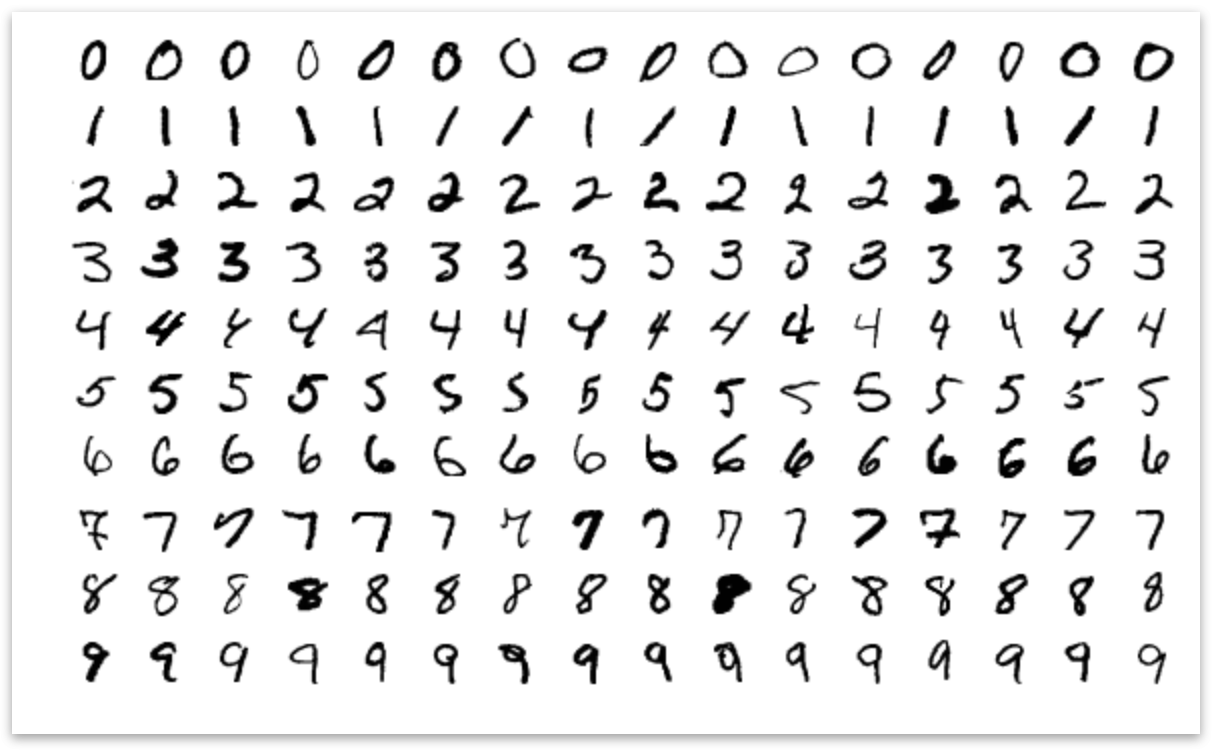

## Import

First let's import some packages that we'll need throughout the notebook

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.transform import resize
import matplotlib.pyplot as plt
import os

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# MNIST Data

Then we download the MNIST dataset. We have 60k images in the train set and 10k images in the test set. We combine the two.

In [80]:
(images1, _), (images2, _) = tf.keras.datasets.mnist.load_data()

In [81]:
images1.shape, images2.shape

((60000, 28, 28), (10000, 28, 28))

Let's resize the images so it matches the size of the paper: 64 x 64 instead of 32 x 32.

In [82]:
n = 30000

In [83]:
images11 = resize(images1[:n], (images1[:n].shape[0], 64, 64, 1), preserve_range=True).astype("float32")

In [84]:
images12 = resize(images1[n:], (images1[n:].shape[0], 64, 64, 1), preserve_range=True).astype("float32")

In [85]:
images21 = resize(images2, (images2.shape[0], 64, 64, 1), preserve_range=True).astype("float32")

In [86]:
images11.shape, images12.shape, images21.shape

((30000, 64, 64, 1), (30000, 64, 64, 1), (10000, 64, 64, 1))

In [87]:
images = tf.concat([images11, images12, images21], 0)

The images also need to be normalized

In [88]:
images = (images - 127.5) / 127.5

Let's see a sample of these images

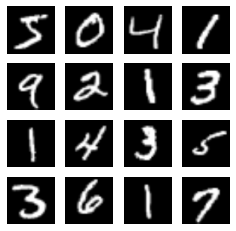

In [89]:
fig = plt.figure(figsize=(4, 4))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()

In [90]:
buffer = 60000
batch_size = 100

data_generator = tf.data.Dataset.from_tensor_slices(images).shuffle(buffer).batch(batch_size, drop_remainder=True)

# Part 1: Deep Convolutional GAN (DCGAN)

In this first section we are going to code a Deep Convolutional GAn which is basically a GAN only made of convolution layers.

## Discriminator

First let's build our discriminator.

In [91]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Flatten, Input, LeakyReLU, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal

Our input is of size 64 x 64. With a kernel size of 5, a  stride of 2 and a padding "same" the first convolutional layer output an image of size 32 x 32. The start padding is of size:

$$
P_{start} =
\left \lfloor{
\frac{
    2 \left \lceil{\frac{64}{2}} \right \rceil -64 + 5 - 2
}{2}
}\right \rfloor
= 
\left \lfloor{
    \frac{3}{2}
}\right \rfloor
= 1
$$

and the end padding:

$$
P_{end} =
\left \lceil{
\frac{
    2 \left \lceil{\frac{64}{2}} \right \rceil -64 + 5 - 2
}{2}
}\right \rceil
= 
\left \lceil{
    \frac{3}{2}
}\right \rceil
= 2
$$

which gives an ouptut size:

$$
O = \frac{64 - 5 +1 + 2}{2} + 1 = 32
$$

Same goes for each convolutional layer: the output gets divided by 2 at each step.

In [92]:
def discriminator():
    input_image = Input(shape=(64, 64, 1))

    x = Conv2D(128,
               kernel_size=5,
               strides=2,
               padding="same",
               kernel_initializer=RandomNormal(stddev=0.02))(input_image)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256,
               kernel_size=5,
               strides=2,
               padding="same",
               kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512,
               kernel_size=5,
               strides=2,
               padding="same",
               kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1024,
               kernel_size=5,
               strides=2,
               padding="same",
               kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1,
               kernel_size=4,
               strides=2,
               padding="valid",
               kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = Flatten()(x)
    x = Dense(1, activation="sigmoid")(x)

    return Model(inputs=input_image, outputs=x)

discriminator = discriminator()

discriminator.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 32, 32, 128)       3328      
_________________________________________________________________
batch_normalization_78 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_78 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
batch_normalization_79 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_79 (LeakyReLU)   (None, 16, 16, 256)       0  

As in the paper we are alterning between convolution, batch normlisation and LeakyReLU until the output size is 1 x 1. This gives our final output followed by a sigmoid function (binary output).

## Generator

Same goes for the generator but it is all inverted: the input is a random vector $z$ of size 100 and we only use transpose convolutional layers. The dimension of the output doubles at each layer until it reaches 64 x 64 which is the original image size.

In [93]:
def generator():
    input_noise = Input(shape=(1, 1, 100))

    x = Conv2DTranspose(1024,
                        kernel_size=4,
                        strides=1,
                        padding="valid",
                        kernel_initializer=RandomNormal(stddev=0.02))(input_noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(512,
                        kernel_size=5,
                        strides=2,
                        padding="same",
                        kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(256,
                        kernel_size=5,
                        strides=2,
                        padding="same",
                        kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(128,
                        kernel_size=5,
                        strides=2,
                        padding="same",
                        kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(1,
                        kernel_size=5,
                        strides=2,
                        padding="same",
                        activation="tanh",
                        kernel_initializer=RandomNormal(stddev=0.02))(x)

    return Model(inputs=input_noise, outputs=x)

generator = generator()

generator.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1, 1, 100)]       0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 4, 4, 1024)        1639424   
_________________________________________________________________
batch_normalization_82 (Batc (None, 4, 4, 1024)        4096      
_________________________________________________________________
leaky_re_lu_82 (LeakyReLU)   (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 8, 8, 512)         13107712  
_________________________________________________________________
batch_normalization_83 (Batc (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_83 (LeakyReLU)   (None, 8, 8, 512)         0  

## Training

Now the training part ! First let's tackle the optimizer. As in the paper we chose Adam with a $10^{-4}$ learning rate which is pretty standard of this kind of task. This for both the Discrimiantor and the Generator.

In [100]:
from tensorflow.keras.optimizers import Adam

optimizer_d = Adam(learning_rate=1e-4, beta_1=0.5)
optimizer_g = Adam(learning_rate=1e-4, beta_1=0.5)

Now the loss. The **discriminator loss** has two components: 

*   The `real loss`: we put real images (taken from the original dataset) in the discriminator and expect it to return 1 ;
*   The `fake loss`: we put fakes images (produced by the generator) and expect it to return 0.

We then compute the following loss for a batch of $m$ samples:

$$
J^{(D)}
=
\underbrace{
\frac{1}{2 m} \sum_{i=1}^{m}\left[\log D\left(x^{(i)}\right)\right]
}_{\text{Real loss}}
+
\underbrace{
\frac{1}{2 m} \sum_{i=1}^{m}\left[ \log \left( 1 - D\left(G\left(z^{(i)}\right)\right)\right)\right]
}_{\text{Fake loss}}
$$

The **generator loss** is simpler and works with a single component: we put a random vector $z$ in the generator which outputs a fake image that is then put in the discriminator and we expect it to return 1 (the genertor tries to fool the discrimiantor). The loss is as well computed on a batch of $m$ samples.

$$
J^{(G)}=\frac{1}{m} \sum_{i=1}^{m}\left[ \log D\left(G\left(z^{(i)}\right)\right)\right]
$$

Note that we only used binary cross entropy loss here as we found that using it makes our network more stable.

In [101]:
from tensorflow.keras.losses import BinaryCrossentropy

cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Then the **training loop**

In [102]:
@tf.function
def trainGAN(real_images):
    # Get random noise to use in the generator
    random_noise = tf.random.normal(shape=(batch_size,1,1,100))

    # Call for GradientTape so it records the operations and can calculate the gradient of
    # each variable
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        # Generate the fake images based on the random noise vector z
        generated_images = generator(random_noise, training=True)

        # Put the fake and real images in the discriminator, get two outputs
        fake_output = discriminator(generated_images, training=True)
        real_output = discriminator(real_images, training=True)

        # Use the output to compute the loss
        d_loss = discriminator_loss(real_output, fake_output)
        g_loss = generator_loss(fake_output)

    # Compute the gradient of the loss wrt the trainable variables of both neural networks
    grads_d = d_tape.gradient(d_loss, discriminator.trainable_weights)
    grads_g = g_tape.gradient(g_loss, generator.trainable_weights)

    # Compute the gradient step using the defined optimizer
    optimizer_d.apply_gradients(zip(grads_d, discriminator.trainable_weights))
    optimizer_g.apply_gradients(zip(grads_g, generator.trainable_weights))

    # Output the two losses to monitor the training
    return d_loss, g_loss

In [103]:
# Saving device in case of runtime disconnection
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=optimizer_g,
                                 discriminator_optimizer=optimizer_d,
                                 generator=generator,
                                 discriminator=discriminator)

In [104]:
# Function that will print the images generated by our generator along the training process
# Note: we will always use the same seed to see the generator learning the latent space
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

====== Epoch  0 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 600 ... 650 ... 
Discriminator: 0.7391225695610046, Generator: 10.57569408416748


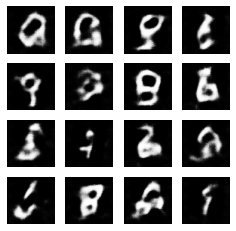

====== Epoch  1 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 600 ... 650 ... 
Discriminator: 0.5700477361679077, Generator: 4.52572774887085


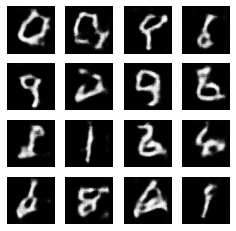

====== Epoch  2 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 600 ... 650 ... 
Discriminator: 0.5671119689941406, Generator: 4.05502462387085


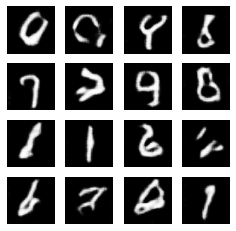

====== Epoch  3 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 600 ... 650 ... 
Discriminator: 0.45618486404418945, Generator: 4.255497932434082


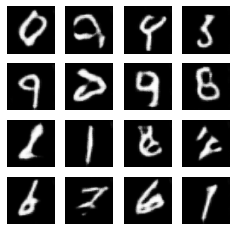

====== Epoch  4 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 600 ... 650 ... 
Discriminator: 0.4573526382446289, Generator: 4.05068302154541


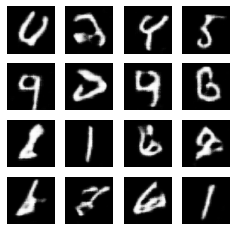

====== Epoch  5 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 600 ... 650 ... 
Discriminator: 0.22733519971370697, Generator: 4.7865824699401855


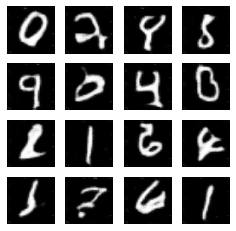

====== Epoch  6 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 600 ... 650 ... 
Discriminator: 0.5017491579055786, Generator: 4.43742036819458


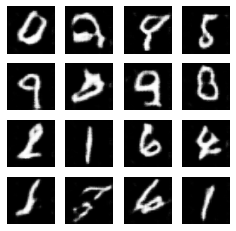

====== Epoch  7 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 600 ... 650 ... 
Discriminator: 0.3086199164390564, Generator: 4.834113121032715


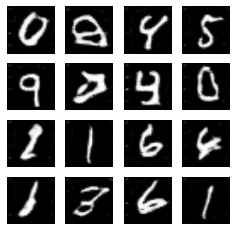

====== Epoch  8 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 600 ... 650 ... 
Discriminator: 0.3762698471546173, Generator: 4.000971794128418


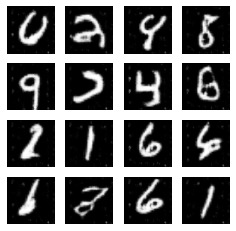

====== Epoch  9 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 600 ... 650 ... 
Discriminator: 0.4778178334236145, Generator: 4.366185665130615


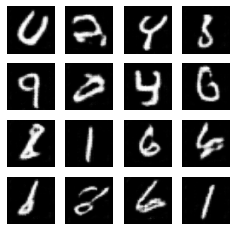

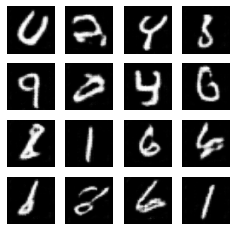

In [105]:
from tensorflow.keras.metrics import Mean
from IPython.core.display import display as jupy_display

epochs = 10

# The seed we use to generate images along the training
seed = tf.random.normal(shape=(batch_size,1,1,100))

# Loop over epochs
for epoch in range(epochs):
    print("====== Epoch {:2d} ======".format(epoch))

    # To compute the average loss over the batch
    epoch_loss_d = Mean()
    epoch_loss_g = Mean()
    
    # Loop over the batches
    epoch_len = tf.data.experimental.cardinality(data_generator)
    for i, real_images in enumerate(data_generator):
        loss_d, loss_g = trainGAN(real_images)
        epoch_loss_d(loss_d)
        epoch_loss_g(loss_g)
        
        if i % 50 == 0 and i > 0:
            print(i, end=" ... ")
            
    print("\nDiscriminator: {}, Generator: {}".format(epoch_loss_d.result(), epoch_loss_g.result()))

    # Saves the model at each epoch
    checkpoint.save(file_prefix = checkpoint_prefix)

    # Produces images at each epoch
    generate_and_save_images(generator, epoch + 1, seed)

generate_and_save_images(generator, epochs, seed)

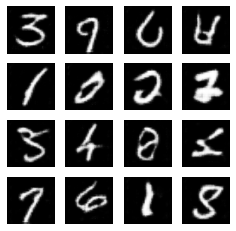

In [106]:
random_noise = tf.random.normal(shape=(batch_size,1,1,100))

fake_images = generator(random_noise, training=False)

fig = plt.figure(figsize=(4, 4))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(fake_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()

# USPS Data

For the second task we also need the USPS data. We get them through our GitHub for convenience.

In [ ]:
!git clone https://github.com/maximeberillon/DCGAN_cycleGAN

In [ ]:
import h5py

path = '/content/DCGAN_cycleGAN/data/usps.h5'

with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_train = train.get('data')[:]
        test = hf.get('test')
        X_test = test.get('data')[:]

In [27]:
usps_images = tf.concat([X_train, X_test], 0)
usps_images.shape

TensorShape([9298, 256])

In [28]:
usps_images = tf.reshape(usps_images, [usps_images.shape[0], 16, 16])
usps_images.shape

TensorShape([9298, 16, 16])

They follow the same pre-processing steps with resizing, noramlization + a conversion into tensors.

In [29]:
usps_images = resize(usps_images, (usps_images.shape[0], 64, 64, 1), preserve_range=True).astype("float32")

In [30]:
usps_images = (usps_images - 127.5) / 127.5

In [31]:
usps_images = tf.convert_to_tensor(usps_images, dtype=tf.float32) 

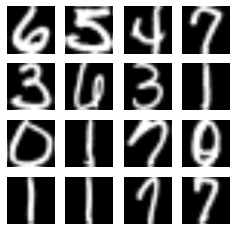

In [32]:
fig = plt.figure(figsize=(4, 4))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(usps_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()

We can already see that the numbers are **bolder** that in the MNIST dataset which is something the cycleGAN will have to reproduce.

# Part 2: cycleGAN

We pad both datasets so they have the same length

In [33]:
size = 9200

usps_images = usps_images[:size]
mnist_images = images[:size]

usps_images.shape, mnist_images.shape

(TensorShape([9200, 64, 64, 1]), TensorShape([9200, 64, 64, 1]))

## Blocks

Here we define the different blocks we will use to build our cycle GAN:

* First the `downsample` block that will *encode* the input using a convolutional layer ;
* Then the `residual` block that transforms the input but keeps the same output size ;
* Finally the `upsample` that does the opposite job and *decodes* the input with a transpose convolutional layer.

In [34]:
# The downsample block

def downsample(x, filters):
    x = Conv2D(
        filters,
        kernel_size=3,
        strides=2,
        kernel_initializer=RandomNormal(stddev=0.02),
        padding='same'
    )(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [35]:
# The upsample block

def upsample(x, filters, relu_activation=True, batch_norm=True):
    x = Conv2DTranspose(
        filters,
        kernel_size=3,
        strides=2,
        kernel_initializer=RandomNormal(stddev=0.02),
        padding='same'
    )(x)
    if batch_norm==True:
        x = BatchNormalization()(x)
    if relu_activation==True:
        x = LeakyReLU(alpha=0.2)(x)
    else:
        x = Activation("tanh")(x)
    return x

Instead of using the zero padding method we chose to use the Reflection Padding methos to avoid the edge effects the former can introduce. it will be used in the `residual` block to ensure the output shape is the same as the input.

In [36]:
from tensorflow.keras.layers import Layer

class ReflectionPadding2D(Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


In [37]:
# The residual block

def residual_block(x):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = Conv2D(
        dim,
        kernel_size=3,
        strides=1,
        kernel_initializer=RandomNormal(stddev=0.02),
        padding='valid'
    )(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = ReflectionPadding2D()(input_tensor)
    x = Conv2D(
        dim,
        kernel_size=3,
        strides=1,
        kernel_initializer=RandomNormal(stddev=0.02),
        padding='valid'
    )(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = add([input_tensor, x])
    return x

Now we can define our generator by choosing the number or downsample, upsample or residual blocks we want.

In [38]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, add
from tensorflow.keras.layers import BatchNormalization, Flatten, Input
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal

def generator_cycle(num_downsampling_blocks=2,
                  num_residual_blocks=9,
                  num_upsample_blocks=2):

    filters = 32

    img_input = Input(shape=(64, 64, 1))
    x = Conv2D(filters, 5, 2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(img_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters)

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x)

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, relu_activation=True, batch_norm=True)

    # Final block
    x = upsample(x, 1, relu_activation=False, batch_norm=False)

    model = Model(img_input, x)
    return model

## Generators

We define our two generator: F and G.

In [39]:
gen_G = generator_cycle()
gen_F = generator_cycle()

In [40]:
gen_G.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 32)   832         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 32, 32, 32)   128         conv2d_5[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 32, 32, 32)   0           batch_normalization_8[0][0]      
____________________________________________________________________________________________

## Discriminators

The discriminator architecture is the same as for DCGAN

In [41]:
def discriminator():
    input_image = Input(shape=(64, 64, 1))

    x = Conv2D(128,
               kernel_size=5,
               strides=2,
               padding="same",
               kernel_initializer=RandomNormal(stddev=0.02))(input_image)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256,
               kernel_size=5,
               strides=2,
               padding="same",
               kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512,
               kernel_size=5,
               strides=2,
               padding="same",
               kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1024,
               kernel_size=5,
               strides=2,
               padding="same",
               kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1,
               kernel_size=4,
               strides=2,
               padding="valid",
               kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = Flatten()(x)
    x = Dense(1, activation="sigmoid")(x)

    return Model(inputs=input_image, outputs=x)

In [42]:
disc_X = discriminator()
disc_Y = discriminator()

In [43]:
disc_X.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 128)       3328      
_________________________________________________________________
batch_normalization_54 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
batch_normalization_55 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 16, 16, 256)       0   

We define G and F as follow:

$G : X \rightarrow Y$

$F : Y \rightarrow X$

with $X$ being the USPS data and $Y$ the MNIST data.

## Training

In [44]:
# The batch size here is one as adviced
batch_size = 1

# We merge the two datasets that will be used here
usps_data = tf.data.Dataset.from_tensor_slices(usps_images).shuffle(size).batch(batch_size, drop_remainder=True)
mnist_data = tf.data.Dataset.from_tensor_slices(mnist_images).shuffle(size).batch(batch_size, drop_remainder=True)

data_generator = tf.data.Dataset.zip((usps_data, mnist_data))

First we define the discriminator and generator losses as in the DCGAN. Note that here we chose the Least Square Loss as it was more stable during the training.

In [53]:
from tensorflow.keras.losses import mean_squared_error

def discriminator_loss(real_output, fake_output):
    real_loss = mean_squared_error(tf.ones_like(real_output), real_output)
    fake_loss = mean_squared_error(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return mean_squared_error(tf.ones_like(fake_output), fake_output)

On top of that we define the `cycle loss`: the idea behind this is to have consistency in the translation. Translating an image from USPS to MNIST and then from MNIST to USPS should output something very close to the original input.

$$
\mathcal{J}_{\text {cycle }}^{(X \rightarrow Y \rightarrow X)}=\frac{1}{m} \sum_{i=1}^{m}\left\|y^{(i)}-G_{X \rightarrow Y}\left(G_{Y \rightarrow X}\left(y^{(i)}\right)\right)\right\|_{1}
$$

We use here the Mean Absolute error.

In [54]:
from tensorflow.keras.losses import MeanAbsoluteError

# Define the loss used in the cycle_loss
cycle_loss = MeanAbsoluteError()

# Define our optimizers
gen_G_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
gen_F_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
disc_X_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
disc_Y_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)

# Our training function
@tf.function
def traincycleGAN(x_data, y_data, lambda_cycle=10.0):
    # Recording every function used in order to compute the gradient later
    with tf.GradientTape(persistent=True) as tape:
        # Go from X to Y and from Y to X
        y_fake = gen_G(x_data, training=True)
        x_fake = gen_F(y_data, training=True)

        # Use the generators' output to translate again
        x_cycled = gen_F(y_fake, training=True)
        y_cycled = gen_G(x_fake, training=True)

        # Put the real and fake X data in the X discriminator
        x_disc_real = disc_X(x_data, training=True)
        x_disc_fake = disc_X(x_fake, training=True)

        # Put the real and fake Y data in the Y discriminator
        y_disc_real = disc_Y(y_data, training=True)
        y_disc_fake = disc_Y(y_fake, training=True)

        # Compute the generator loss based on each discriminator's output
        gen_loss_G = generator_loss(y_disc_fake)
        gen_loss_F = generator_loss(x_disc_fake)

        # Compute the cycle loss based on the cycled data computed using both generators
        cycle_loss_G = cycle_loss(y_data, y_cycled) * lambda_cycle
        cycle_loss_F = cycle_loss(x_data, x_cycled) * lambda_cycle

        # Add these to have the total loss
        total_loss_G = gen_loss_G + cycle_loss_G
        total_loss_F = gen_loss_F + cycle_loss_F

        # Compute the discriminators loss using real and fake data
        disc_X_loss = discriminator_loss(x_disc_real, x_disc_fake)
        disc_Y_loss = discriminator_loss(y_disc_real, y_disc_fake)

    # Get the gradients for the generators
    grads_G = tape.gradient(total_loss_G, gen_G.trainable_variables)
    grads_F = tape.gradient(total_loss_F, gen_F.trainable_variables)

    # Get the gradients for the discriminators
    disc_X_grads = tape.gradient(disc_X_loss, disc_X.trainable_variables)
    disc_Y_grads = tape.gradient(disc_Y_loss, disc_Y.trainable_variables)

    # Update the weights of the generators
    gen_G_optimizer.apply_gradients(
        zip(grads_G, gen_G.trainable_variables)
    )
    gen_F_optimizer.apply_gradients(
        zip(grads_F, gen_F.trainable_variables)
    )

    # Update the weights of the discriminators
    disc_X_optimizer.apply_gradients(
        zip(disc_X_grads, disc_X.trainable_variables)
    )
    disc_Y_optimizer.apply_gradients(
        zip(disc_Y_grads, disc_Y.trainable_variables)
    )

    return total_loss_G, total_loss_F, disc_X_loss, disc_Y_loss

In [55]:
# Again a saving device
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(gen_G_optimizer=gen_G_optimizer,
                                 gen_F_optimizer=gen_F_optimizer,
                                 disc_X_optimizer=disc_X_optimizer,
                                 disc_Y_optimizer=disc_Y_optimizer,
                                 gen_F=gen_F,
                                 gen_G=gen_G,
                                 disc_X=disc_X,
                                 disc_Y=disc_Y)

In [56]:
# Again a function to see the progress of the cycleGAN
def generate_and_save_images_cycle(generator, epoch, input):
    f, axarr = plt.subplots(2,5, figsize=(5, 10))
    f.subplots_adjust(hspace = 0.1, wspace=0.1)

    for i, elem in enumerate(input.take(5)):
        axarr[0,i].imshow(elem[0,:,:,0] * 127.5 + 127.5, cmap='gray')
        axarr[0,i].axis('off')
        axarr[1,i].imshow(generator(elem)[0,:,:,0] * 127.5 + 127.5, cmap='gray')
        axarr[1,i].axis('off')
    
    if input==usps_data:
        X_ = 'USPS'
        Y_ = 'MNIST'
    else:
        Y_ = 'USPS'
        X_ = 'MNIST'

    axarr[0,0].set_title(X_, fontsize=14)
    axarr[1,0].set_title(Y_, fontsize=14)

    plt.subplots_adjust(bottom=0.4, top=0.6)

    plt.savefig('image_at_epoch_{:04d}_{}_{}.png'.format(epoch, X_, Y_))
    plt.show()

In [57]:
# An epoch counter to train the cycleGAN in two or more times
epoch_counter = 0

====== Epoch 15 ======
1000 ... 2000 ... 3000 ... 4000 ... 5000 ... 6000 ... 7000 ... 8000 ... 9000 ... 
=====USPS to MNIST=====


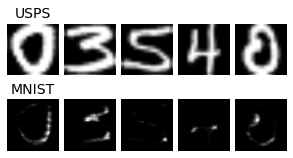


=====USPS to MNIST=====


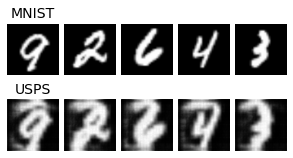


Generator G: [1.2914317], Generator F: [1.0013592]
Discriminator X: [1.], Discriminator Y: [4.8982884e-07]
====== Epoch 16 ======
1000 ... 2000 ... 3000 ... 4000 ... 5000 ... 6000 ... 7000 ... 8000 ... 9000 ... 
=====USPS to MNIST=====


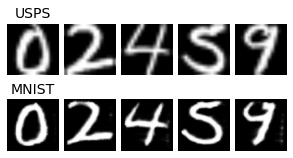


=====USPS to MNIST=====


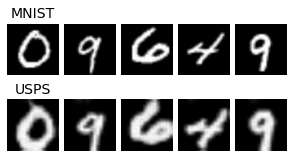


Generator G: [1.1424668], Generator F: [1.0025691]
Discriminator X: [1.], Discriminator Y: [1.6270009e-10]
====== Epoch 17 ======
1000 ... 2000 ... 3000 ... 4000 ... 5000 ... 6000 ... 7000 ... 8000 ... 9000 ... 
=====USPS to MNIST=====


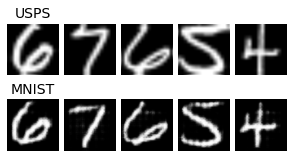


=====USPS to MNIST=====


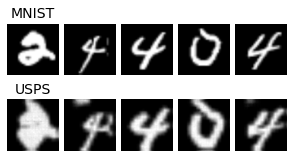


Generator G: [1.221797], Generator F: [1.0011511]
Discriminator X: [1.], Discriminator Y: [6.9396376e-20]
====== Epoch 18 ======
1000 ... 2000 ... 

KeyboardInterrupt: ignored

In [61]:
epochs_to_run = 15

# We chose to stick with a lambda of 10 for the importance of the cycle loss
lambda_cycle = 10

for _ in range(epochs_to_run):
    print("====== Epoch {:2d} ======".format(epoch_counter))
    
    for i, data in enumerate(data_generator):
        total_loss_G, total_loss_F, disc_X_loss, disc_Y_loss = \
            traincycleGAN(data[0], data[1], lambda_cycle=lambda_cycle)
        
        if i % 1000 == 0 and i > 0:
            print(i, end=" ... ")
    
    checkpoint.save(file_prefix = checkpoint_prefix)

    print('\n=====USPS to MNIST=====')
    generate_and_save_images_cycle(gen_G, epoch_counter, usps_data)
    print('\n=====USPS to MNIST=====')
    generate_and_save_images_cycle(gen_F, epoch_counter, mnist_data)
            
    print("\nGenerator G: {}, Generator F: {}".format(total_loss_G, total_loss_F))
    print("Discriminator X: {}, Discriminator Y: {}".format(disc_X_loss, disc_Y_loss))

    epoch_counter += 1

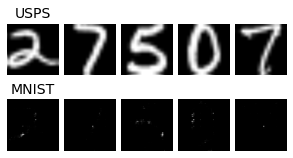

In [67]:
generate_and_save_images_cycle(gen_G, 100, usps_data)

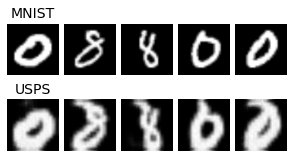

In [63]:
generate_and_save_images_cycle(gen_F, 100, mnist_data)